In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

import pandas as pd
import numpy as np


In [2]:
import random
np.random.seed(1234)
random.seed(1234)

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [4]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [6]:
train_df['MSZoning'].value_counts()

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

In [8]:
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

In [9]:

from sklearn.preprocessing import LabelEncoder

In [10]:

categories = all_df.columns[all_df.dtypes == "object"]
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [11]:

for cat in categories:
    le = LabelEncoder()
    print(cat)
    
    all_df[cat].fillna("missing", inplace=True)    
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype("category")

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [12]:
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]

In [13]:

import lightgbm as lgb

In [14]:

from sklearn.model_selection import KFold
folds = 3
kf = KFold(n_splits=folds)

In [15]:

lgbm_params = {
    "objective":"regression",
    "random_seed":1234
}

In [16]:
train_X = train_df_le.drop(["SalePrice", "Id"], axis=1)
train_Y = train_df_le["SalePrice"]

In [17]:
from sklearn.metrics import mean_squared_error

In [18]:

models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    print(X_train)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
487           20        3         70.0    12243      1     2        0   
488          190        3         60.0    10800      1     2        3   
489          180        4         21.0     1526      1     2        3   
490          160        4          NaN     2665      1     2        3   
491           50        3         79.0     9490      1     2        3   
...          ...      ...          ...      ...    ...   ...      ...   
1455          60        3         62.0     7917      1     2        3   
1456          20        3         85.0    13175      1     2        3   
1457          70        3         66.0     9042      1     2        3   
1458          20        3         68.0     9717      1     2        3   
1459          20        3         75.0     9937      1     2        3   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC Fence  \
487            3         0         4  ...   

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 1.78839e+09
[20]	valid_0's l2: 1.03494e+09
[30]	valid_0's l2: 8.76655e+08
[40]	valid_0's l2: 8.61221e+08
[50]	valid_0's l2: 8.70283e+08
[60]	valid_0's l2: 8.52573e+08
[70]	valid_0's l2: 8.36406e+08
[80]	valid_0's l2: 8.38037e+08
[90]	valid_0's l2: 8.45503e+08
[100]	valid_0's l2: 8.45187e+08
Did not meet early stopping. Best iteration is:
[81]	valid_0's l2: 8.35675e+08
0.1327709996964391


In [19]:
sum(rmses)/len(rmses)

0.13606875326522938

In [21]:

actual_pred_df = pd.DataFrame({
    "actual" : train_Y,
    "pred" : oof })

<Axes: >

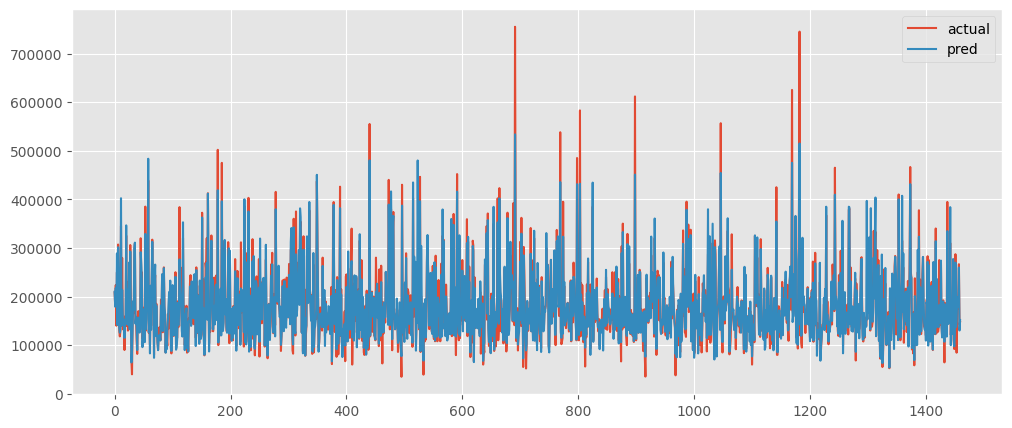

In [22]:

actual_pred_df.plot(figsize=(12,5))

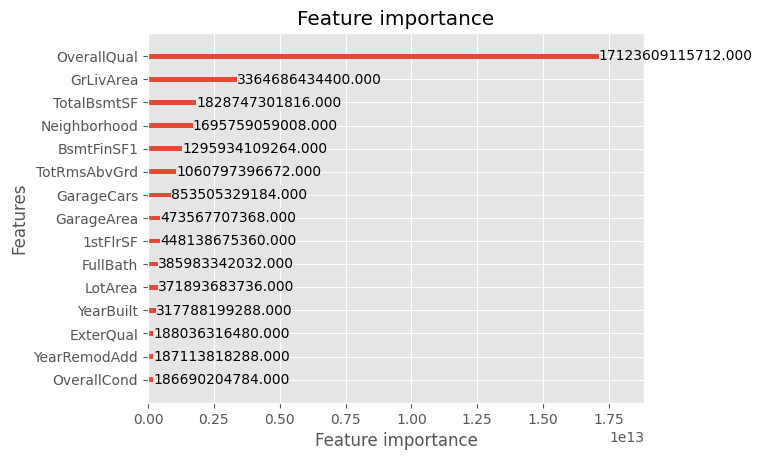

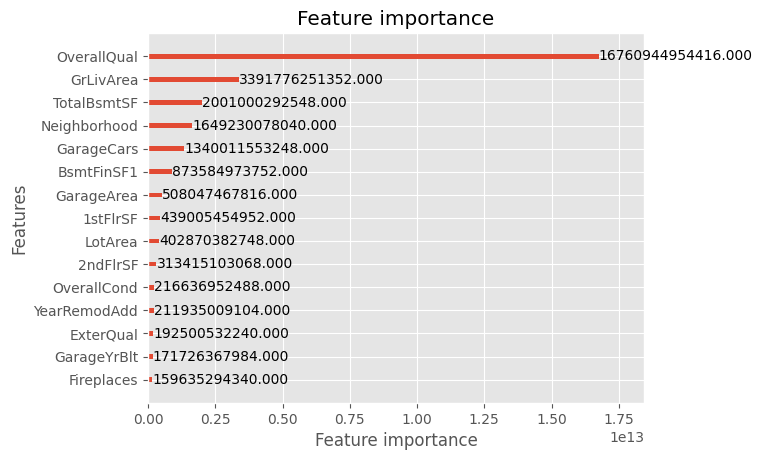

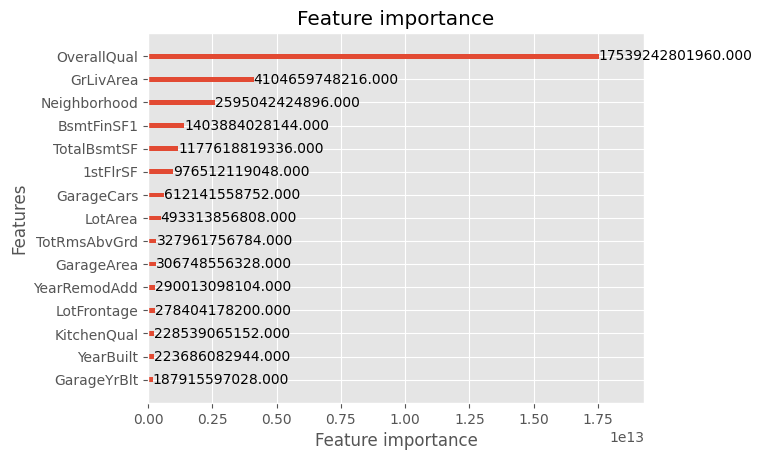

In [23]:
for model in models:
    lgb.plot_importance(model,importance_type="gain", max_num_features=15)

In [24]:

pd.options.mode.chained_assignment = None
train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])

In [25]:
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [26]:
import warnings
warnings.filterwarnings("ignore")

models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0435757
[20]	valid_0's l2: 0.0222742
[30]	valid_0's l2: 0.0178641
[40]	valid_0's l2: 0.0167218
[50]	valid_0's l2: 0.0164435
[60]	valid_0's l2: 0.0162049
[70]	valid_0's l2: 0.0160662
[80]	valid_0's l2: 0.0159922
[90]	valid_0's l2: 0.0160502
Early stopping, best iteration is:
[75]	valid_0's l2: 0.0159661
0.12635697731896975
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.048724
[20]	valid_0's l2: 0.0277188
[30]	valid_0's l2: 0.0226077
[40]	valid_0's l2: 0.0211534
[50]	valid_0's l2: 0.0206503
[60]	valid_0's l2: 0.0204751
[70]	valid_0's l2: 0.0203809
[80]	valid_0's l2: 0.0203424
[90]	valid_0's l2: 0.0202764
[100]	valid_0's l2: 0.020244
Did not meet early stopping. Best iteration is:
[94]	valid_0's l2: 0.0202107
0.14216440722442905
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0387887
[20]	valid_0's l2: 0.0208522
[30]	valid_0's l2: 0.0175332

In [27]:

sum(rmses)/len(rmses)

0.13229746601315612